In [1]:
import os, shutil, torch
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Spacingd,
    MapTransform,
    ToTensord,
    ConcatItemsd
)
from monai.data import Dataset, DataLoader
import nibabel as nib
import numpy as np 
from monai import transforms, data
import matplotlib.pyplot as plt 

class ConvertLabelBasedOnClasses(MapTransform):
    def __call__(self, data):
        d = dict(data)
        # print(data)
        for key in self.keys:
            result = d[key] > 1
            d[key] = result.float()
        return d

class DeleteDataKeysd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            del d[key]
        return d

PAIs249 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.9770111 5.290596


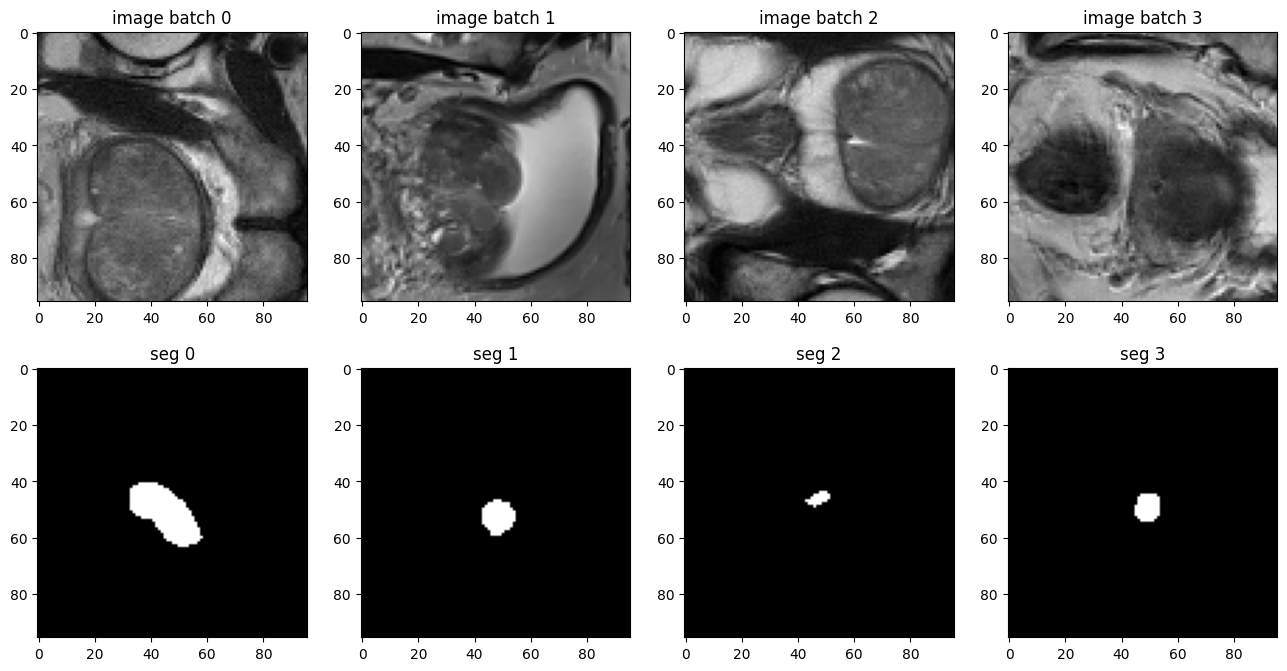

PAIs088 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.8288307 5.060734


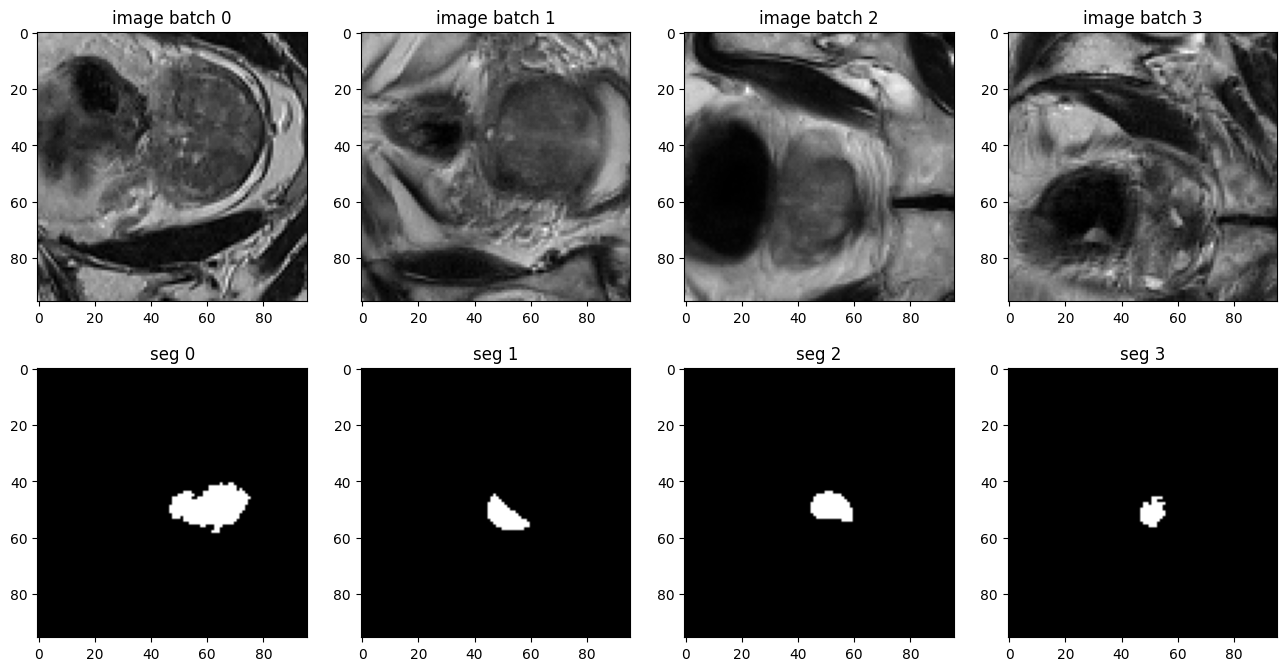

PAIs278 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.8155322 4.3042574


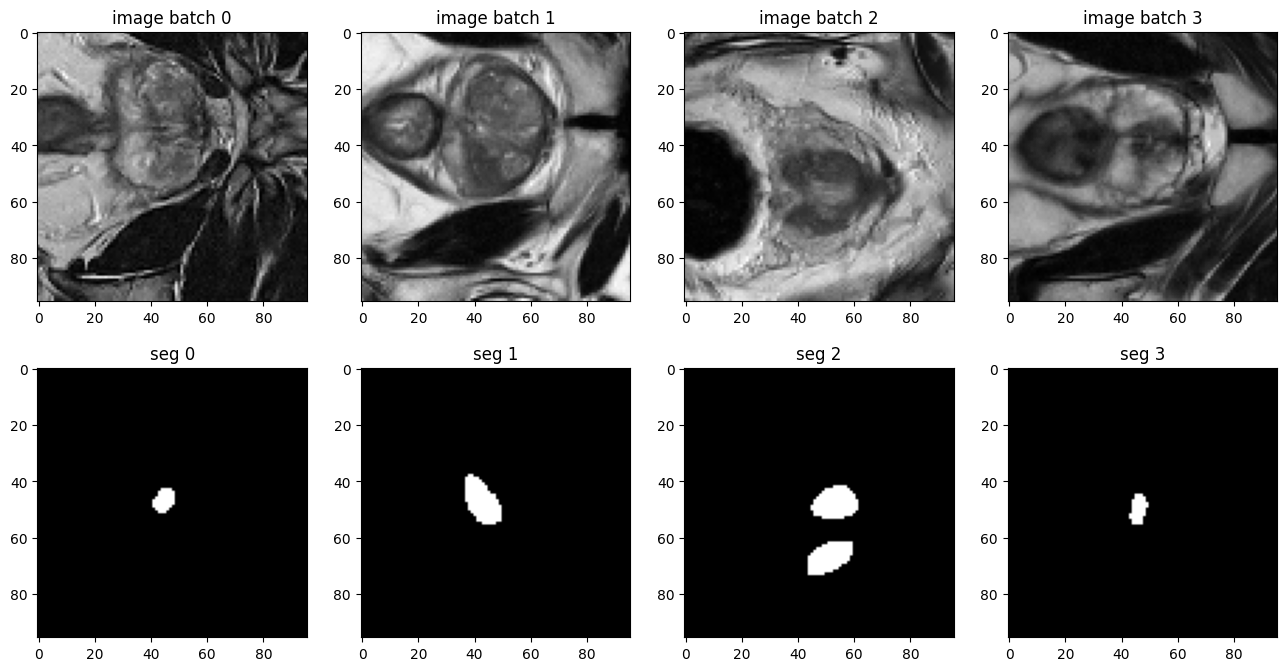

In [6]:
x, y, z = 96, 96, 32
B = 4
modality = 'T2W'
tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
name_list = os.listdir(tiantian_root)
datalist = []
for name in name_list:
    sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz')}
    # for modality in ['T2W', 'DWI', 'ADC']:
    #     sample[modality] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    sample["image"] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    datalist.append(sample)

train_transform = Compose(
    [
        ## load 4 Nifti images and stack them together
        # LoadImaged(keys=["T2W", "DWI", "ADC", "label"]),
        # EnsureTyped(keys=["T2W", "DWI", "ADC", "label"]),
        # ConvertLabelBasedOnClasses(keys="label"),
        # EnsureChannelFirstd(keys=["T2W", "DWI", "ADC", "label"]),
        # ConcatItemsd(keys=["T2W", "DWI", "ADC"], name="image"),
        
        # load single modality
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),

        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[x, y, z]),
        transforms.RandCropByLabelClassesd(
                keys=["image", "label"],
                label_key="label",
                spatial_size=[x, y, z],
                num_classes=2,
                ratios=[0,1],
                num_samples=1,
            ),
        RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        ToTensord(keys=["image", "label"]),
        # DeleteDataKeysd(keys=["T2W", "DWI", "ADC"]),
    ]
)
train_ds = Dataset(data=datalist, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=False, num_workers=0)

for idx, check_data in enumerate(train_loader):
    name = check_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_data['image']
    label = check_data['label']
    print(name, img.shape, label.shape, np.max(label), np.min(img), np.max(img))
    # break
    plt.figure(figsize=(4*B, 8))
    for i in range(B):
        plt.subplot(2, B, i+1)
        plt.title(f"image batch {i}")
        plt.imshow(img[i,0,...,16].detach().cpu(), cmap="gray")

        plt.subplot(2, B, i+1+B)
        plt.title(f"seg {i}")
        plt.imshow(label[i,0,...,16].detach().cpu(), cmap="gray")
    plt.show()
    if idx == 2:
        break

In [8]:
name_list = []
with open('./train_case_level.txt', 'r') as f:
    lines = f.readlines()
    for name in lines:
        name = name.strip()
        name_list.append(name)

tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
adc_list = []
dwi_list = []
t2w_list = []
for name in name_list:
    dwi_gt = nib.load(os.path.join(tiantian_root, name, name+"_DWI_gt.nii.gz")).get_fdata()
    adc_gt = nib.load(os.path.join(tiantian_root, name, name+"_ADC_gt.nii.gz")).get_fdata()
    t2w_gt = nib.load(os.path.join(tiantian_root, name, name+"_T2W_gt.nii.gz")).get_fdata()

    if np.max(dwi_gt) > 1:
        dwi_list.append(name)
    if np.max(adc_gt) > 1:
        adc_list.append(name)
    if np.max(t2w_gt) > 1:
        t2w_list.append(name)

    print(name, np.max(dwi_gt), np.max(adc_gt), np.max(t2w_gt))


def write_list(name_list, save_name):
    with open(save_name, 'w') as f:
        for name in name_list:
            f.write(name)
            f.write('\n')


write_list(adc_list, './ADC.txt')
write_list(dwi_list, './DWI.txt')
write_list(t2w_list, './T2W.txt')




PAIs001 2.0 2.0 2.0
PAIs004 2.0 2.0 2.0
PAIs005 2.0 2.0 3.0
PAIs006 2.0 2.0 2.0
PAIs007 2.0 2.0 2.0
PAIs009 2.0 2.0 2.0
PAIs011 2.0 2.0 2.0
PAIs012 2.0 2.0 2.0
PAIs013 2.0 2.0 2.0
PAIs015 2.0 2.0 2.0
PAIs016 2.0 2.0 2.0
PAIs017 2.0 2.0 2.0
PAIs018 3.0 3.0 3.0
PAIs019 3.0 3.0 3.0
PAIs020 3.0 3.0 3.0
PAIs021 3.0 3.0 3.0
PAIs023 2.0 2.0 2.0
PAIs024 2.0 2.0 2.0
PAIs025 2.0 2.0 2.0
PAIs026 4.0 4.0 4.0
PAIs028 2.0 2.0 2.0
PAIs029 2.0 2.0 2.0
PAIs030 2.0 2.0 2.0
PAIs031 2.0 2.0 2.0
PAIs032 3.0 3.0 3.0
PAIs033 2.0 2.0 2.0
PAIs035 2.0 2.0 2.0
PAIs036 2.0 2.0 2.0
PAIs037 3.0 3.0 3.0
PAIs038 3.0 3.0 3.0
PAIs039 3.0 3.0 3.0
PAIs040 2.0 2.0 2.0
PAIs042 3.0 3.0 3.0
PAIs043 2.0 2.0 2.0
PAIs044 3.0 3.0 3.0
PAIs045 0.0 0.0 2.0
PAIs046 3.0 3.0 3.0
PAIs047 2.0 2.0 2.0
PAIs048 2.0 2.0 2.0
PAIs050 2.0 2.0 2.0
PAIs051 3.0 3.0 3.0
PAIs052 3.0 3.0 3.0
PAIs056 3.0 3.0 3.0
PAIs057 2.0 2.0 2.0
PAIs058 2.0 2.0 2.0
PAIs060 2.0 2.0 2.0
PAIs061 2.0 2.0 2.0
PAIs062 2.0 2.0 2.0
PAIs063 2.0 2.0 2.0
PAIs064 2.0 2.0 2.0
